In [1]:
# Downloading necessary files (training and validation sets)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2019-05-03 18:12:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   129MB/s    in 1.5s    

2019-05-03 18:12:38 (129 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2019-05-03 18:12:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/r

In [0]:
import os
import zipfile

# Unzipping downloaded training data.
zip_file = zipfile.ZipFile("/tmp/rps.zip", "r")
zip_file.extractall('/tmp/')
zip_file.close()

# Unzipping downloaded validation data.
zip_file = zipfile.ZipFile("/tmp/rps-test-set.zip", "r")
zip_file.extractall('/tmp/')
zip_file.close()

In [4]:
# Getting directories to each training class.
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print("Total number of training rock images: ", len(os.listdir(rock_dir)))
print("Total number of training paper images: ", len(os.listdir(paper_dir)))
print("Total number of training scissors images: ", len(os.listdir(scissors_dir)))

# Printing a few file names from each class so that I can take a look at them.
rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

Total number of training rock images:  840
Total number of training paper images:  840
Total number of training scissors images:  840
['rock04-010.png', 'rock04-039.png', 'rock07-k03-080.png', 'rock02-039.png', 'rock02-048.png', 'rock06ck02-096.png', 'rock03-033.png', 'rock02-114.png', 'rock03-115.png', 'rock05ck01-008.png']
['paper07-082.png', 'paper02-003.png', 'paper07-028.png', 'paper02-034.png', 'paper06-006.png', 'paper07-046.png', 'paper03-075.png', 'paper07-097.png', 'paper02-006.png', 'paper05-109.png']
['testscissors01-076.png', 'scissors02-019.png', 'testscissors01-003.png', 'scissors02-093.png', 'scissors03-090.png', 'testscissors02-076.png', 'testscissors01-115.png', 'scissors03-077.png', 'scissors01-103.png', 'scissors03-024.png']


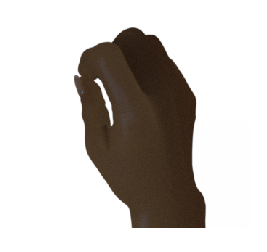

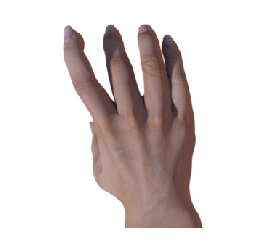

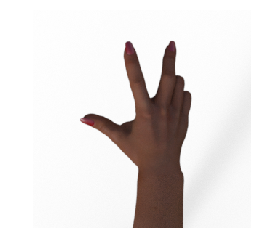

In [10]:
# Showing one image of each class so that I can take a look at the dataset.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def get_rand_from(l):
  """
  Returns a random element from the list 'l'.
  """
  return l[random.randint(0, len(l) - 1)]

rock = get_rand_from(rock_files)
paper = get_rand_from(paper_files)
scissors = get_rand_from(scissors_files)
dirs = [rock_dir, paper_dir, scissors_dir]

for i, fname in enumerate([rock, paper, scissors]):
  img = mpimg.imread(dirs[i] + "/" + fname) # Numpy array.
  plt.imshow(img)
  plt.axis("off")
  plt.show()


In [11]:
# Setting up image generators for both the training and validation sets and
# setting up parameters to use data augmentation on the training set.
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_data_generator = ImageDataGenerator(
      rescale = 1.0/255.0,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,)

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_data_generator = ImageDataGenerator(rescale = 1.0/255.0)

training_data_generator = training_data_generator.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode="categorical"
)

validation_data_generator = validation_data_generator.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode="categorical"
)

# Creating model architecture.
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 channels.
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

# Printing the model's summary.
model.summary()

# Compiling model.
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Training model.
history = model.fit_generator(training_data_generator, epochs=25, validation_data = validation_data_generator)

model.save("rps.h5")


Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
____

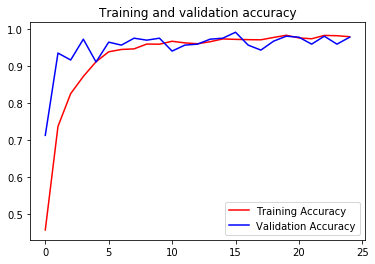

<Figure size 432x288 with 0 Axes>

In [13]:
# Plotting model metrics.
import matplotlib.pyplot as plt
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training Accuracy")
plt.plot(epochs, val_acc, "b", label="Validation Accuracy")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.show()

In [0]:
# Testing our trained model.
import numpy as np
from google.colab import files
from keras.preprocessing import image

classes = ["paper", "rock", "scissors"]

# Getting files from my file system.
uploaded = files.upload()

for file_name in uploaded.keys():
 
  # Preprocessing upload image(s).
  img = image.load_img(file_name, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  
  # Making prediction(s).
  classes = model.predict(images, batch_size=10)
  print(file_name)
  print(classes)
  print("Prediction: {}".format(classes[np.argmax(classes)])

Saving paper2.png to paper2 (1).png
Saving rock-hires2.png to rock-hires2.png
Saving scissors-hires2.png to scissors-hires2.png
Saving paper-hires2.png to paper-hires2.png
Saving paper-hires1.png to paper-hires1.png
Saving rock-hires1.png to rock-hires1 (1).png
Saving scissors-hires1.png to scissors-hires1.png
Saving scissors9.png to scissors9.png
Saving scissors8.png to scissors8.png
Saving scissors7.png to scissors7 (1).png
Saving rock9.png to rock9.png
Saving rock8.png to rock8.png
Saving rock7.png to rock7.png
Saving paper9.png to paper9.png
Saving paper8.png to paper8.png
Saving paper7.png to paper7.png
Saving scissors6.png to scissors6.png
Saving scissors5.png to scissors5.png
Saving scissors4.png to scissors4.png
Saving paper6.png to paper6.png
Saving paper5.png to paper5.png
Saving paper4.png to paper4.png
Saving rock6.png to rock6.png
Saving rock5.png to rock5.png
Saving rock4.png to rock4.png
Saving scissors3.png to scissors3.png
Saving scissors2.png to scissors2.png
Saving s